<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/6b_ac_quita_ruido_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autocodificadores quita ruido


In [1]:
from itertools import islice as take

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import FashionMNIST

from torch.nn import Linear, Flatten, Sigmoid, ReLU
from torch.nn import Sequential

from torch.optim import Adam

mean_ruido = 0.1
std_ruido = 0.2
n_epocas = 30
t_lote = 64

np.random.seed(1)
torch.manual_seed(1)

## Carga de datos
Se carga y preprocesan las imágenes del conjunto Fashion MNIST usando funciones de PyTorch.

In [2]:
ent = FashionMNIST(root='fashion_mnist',
                   train=True,
                   download=True)

prueba = FashionMNIST(root='fashion_mnist',
                      train=False,
                      download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



Debido a que los autocodificadores que vamos a programar tienen únicamente capas densas, es necesario aplanar las imágenes de $28 \times 28$ en vectores de $784$ dimensiones. Además, escalamos las intensidades de gris de 0-255 a 0-1.

In [3]:
X_ent = ent.data.view(ent.data.shape[0], 784) / 255
X_prueba = prueba.data.view(prueba.data.shape[0], 784) / 255

Se define una subclase de `Dataset` que genera una versión ruidosa de cada imagen.

In [4]:
class MiDS(Dataset):    
  def __init__(self, X, mu=0.2, sigma=0.1):
    ruido = torch.randn(X.size()) * sigma + mu
    self.xr = X + ruido
    self.xo = X

  def __getitem__(self, i):
    return self.xr[i], self.xo[i]

  def __len__(self):
    return len(self.xr)

Generamos el cargador de datos usando esta clase para el conjunto de entrenamiento y visualizamos algunas imágenes.

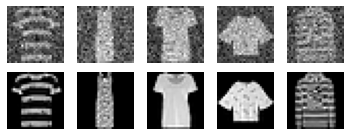

In [5]:
entds = MiDS(X_ent, mu=mean_ruido, sigma=std_ruido)
entdl = DataLoader(entds, 
                   batch_size=t_lote,
                   shuffle=True, 
                   num_workers=0)

fig = plt.figure(figsize=(5, 2))
for xr, xo in take(entdl, 1):
  for i in range(5):
    img_ruidosa = np.floor(xr[i].numpy().reshape(28, 28) * 255)   
    plt.subplot(2, 5, i + 1)
    plt.imshow(img_ruidosa, cmap='gray')
    plt.axis('off')

    img_reconstruida = np.floor(xo[i].numpy().reshape(28, 28) * 255)   
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(img_reconstruida, cmap='gray')
    plt.axis('off')

fig.tight_layout()
plt.show()

También generamos el cargador de datos para el conjunto de prueba y visualizamos algunas imágenes. 

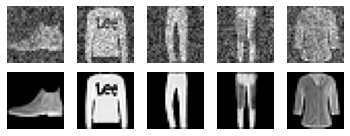

In [6]:
ruido = torch.randn(X_prueba.size()) * std_ruido + mean_ruido
X_prueba_ruidosa = X_prueba + ruido

fig = plt.figure(figsize=(5, 2))
for i in range(5):
  img_ruidosa = np.floor(X_prueba_ruidosa[i].numpy().reshape(28, 28) * 255)   
  plt.subplot(2, 5, i + 1)
  plt.imshow(img_ruidosa, cmap='gray')
  plt.axis('off')

  img_original = np.floor(X_prueba[i].numpy().reshape(28, 28) * 255)   
  ax = plt.subplot(2, 5, i + 1 + 5)
  plt.imshow(img_original, cmap='gray')
  plt.axis('off')

fig.tight_layout()
plt.show()

## Autocodificador contractivo
Se define un autocodificador quita ruido contractivo con únicamente capas densas.

In [7]:
class Autocodificador(torch.nn.Module):
  def __init__(self, d, n_neuronas):
    super(Autocodificador, self).__init__()  
    
    self.cod = Sequential(Linear(d, n_neuronas), 
                           Sigmoid())                
    
    self.dec = Sequential(Linear(n_neuronas, d),
                          Sigmoid())
    
  def forward(self, x):
    z = self.cod(x)
    x = self.dec(z)

    return x, z

Se entrena el autocodificador por 5 épocas con el optimizador Adam y función de pérdida de error cuadrático medio

In [8]:
ac = Autocodificador(X_ent.shape[-1], 100)
opt = Adam(ac.parameters())

perdidas = []
for e in tqdm(range(n_epocas)):   
  perdidas_epoca = [] 
  for xr,xo in entdl:
    xs,z = ac(xr)
    p = F.mse_loss(xs, xo)
    opt.zero_grad()
    p.backward()
    opt.step()
    perdidas_epoca.append(p.item())
      
  perdidas.append(np.mean(perdidas_epoca))

  0%|          | 0/30 [00:00<?, ?it/s]

Se grafica la pérdida por época.

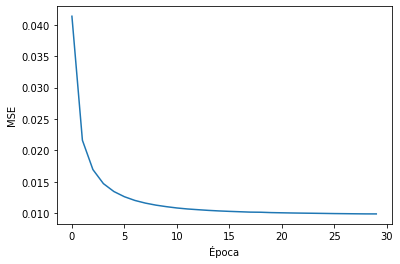

In [9]:
plt.plot(perdidas)
plt.xlabel('Época')
plt.ylabel('MSE')
plt.show()

Se visualizan los resultados con algunos ejemplos del conjunto de validación.

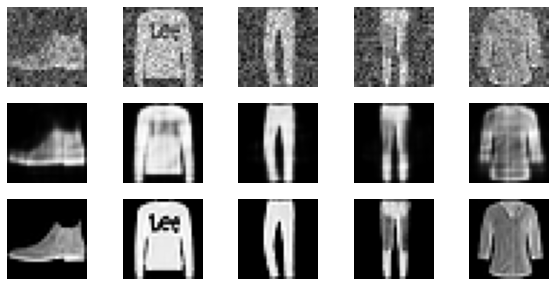

In [10]:
with torch.no_grad():
  pred,z = ac(X_prueba_ruidosa)

plt.figure(figsize=(10, 5))    
for i in range(5):    
  imagen_ruidosa = np.floor(X_prueba_ruidosa[i].reshape(28, 28) * 255) 
  ax = plt.subplot(3, 5, i + 1)
  plt.imshow(imagen_ruidosa, cmap='gray')
  plt.axis('off')

  imagen_reconstruida = np.floor(pred[i].reshape(28, 28) * 255) 
  ax = plt.subplot(3, 5, i + 1 + 5)
  plt.imshow(pred[i].reshape(28, 28) * 255, cmap='gray')
  plt.axis('off')

  imagen_original = np.floor(X_prueba[i].reshape(28, 28) * 255) 
  ax = plt.subplot(3, 5, i + 1 + 10)
  plt.imshow(X_prueba[i].reshape(28, 28) * 255, cmap='gray')
  plt.axis('off')

fig.tight_layout()
plt.show()

## Autocodificador disperso
Se instancia un autocodificador quita ruido agregando un regularizador de activaciones sobre la salida del codificador a la función de pérdida de error cuadrático medio y se entrena por 5 épocas con el optimizador Adam.


In [11]:
acdis = Autocodificador(X_ent.shape[-1], 1200)
opt = Adam(acdis.parameters())

perdidas = []
for e in tqdm(range(n_epocas)):  
  perdidas_epoca = [] 
  for xr,xo in entdl:
    xs, zdis = acdis(xr)
    p = F.mse_loss(xs, xo) + 1e-6 * F.l1_loss(zdis, torch.zeros_like(zdis))
    opt.zero_grad()
    p.backward()
    opt.step()
    perdidas_epoca.append(p.item())
    
  perdidas.append(np.mean(perdidas_epoca))

  0%|          | 0/30 [00:00<?, ?it/s]

Se grafica la pérdida por época.

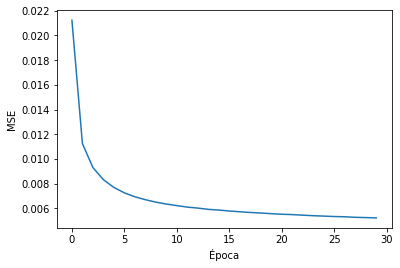

In [12]:
plt.plot(perdidas)
plt.xlabel('Época')
plt.ylabel('MSE')
plt.show()

Se visualizan los resultados con algunos ejemplos del conjunto de validación:

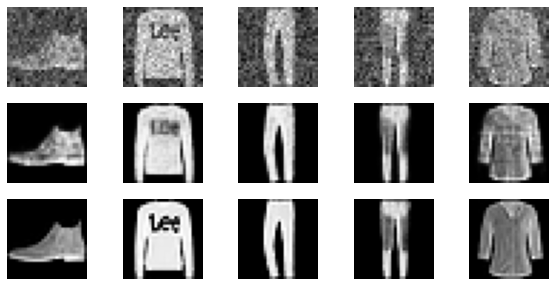

In [13]:
with torch.no_grad():
  preddis,zdis = acdis(X_prueba_ruidosa)

plt.figure(figsize=(10, 5))    
for i in range(5):    
  imagen_ruidosa = np.floor(X_prueba_ruidosa[i].reshape(28, 28) * 255) 
  ax = plt.subplot(3, 5, i + 1)
  plt.imshow(imagen_ruidosa, cmap='gray')
  plt.axis('off')

  imagen_reconstruida = np.floor(preddis[i].reshape(28, 28) * 255) 
  ax = plt.subplot(3, 5, i + 1 + 5)
  plt.imshow(preddis[i].reshape(28, 28) * 255, cmap='gray')
  plt.axis('off')

  imagen_original = np.floor(X_prueba[i].reshape(28, 28) * 255) 
  ax = plt.subplot(3, 5, i + 1 + 10)
  plt.imshow(X_prueba[i].reshape(28, 28) * 255, cmap='gray')
  plt.axis('off')

fig.tight_layout()
plt.show()

Comparamos las activaciones del autocodificador contractivo y el disperso.

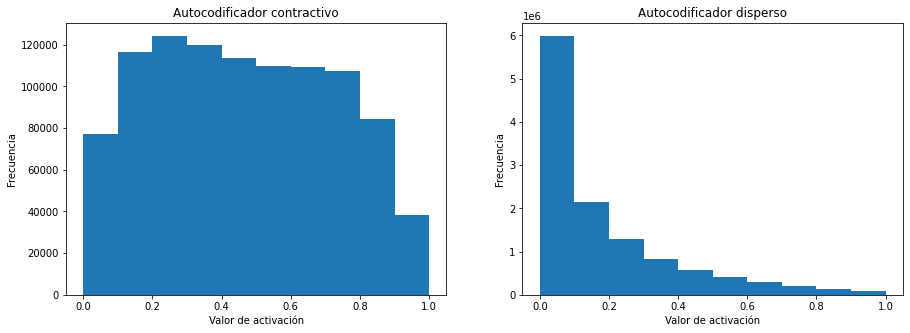

In [14]:
plt.figure(figsize=(15, 5))    

plt.subplot(1, 2, 1)
plt.hist(z.numpy().flatten())
plt.xlabel('Valor de activación')
plt.ylabel('Frecuencia')
plt.title('Autocodificador contractivo')

plt.subplot(1, 2, 2)
plt.hist(zdis.numpy().flatten())
plt.xlabel('Valor de activación')
plt.ylabel('Frecuencia')
plt.title('Autocodificador disperso')

plt.show()